# European Gas Demand Forecasting with Conformal Prediction

This notebook demonstrates **conformal prediction intervals** for real-world energy forecasting using European gas demand data.

## Dataset

- **Source:** European gas demand and weather data (2013-2023)
- **Countries:** 24 European countries
- **Variables:** Temperature, wind speed, gas demand
- **Observations:** ~96,000 daily records

## What We'll Cover

1. **Data Exploration** - Understand demand patterns across countries
2. **Per-Country Forecasting** - Separate models for each country
3. **Conformal Intervals** - Uncertainty quantification for each country
4. **Coverage Analysis** - Verify 95% coverage by country
5. **Interval Width Comparison** - Identify volatile vs stable countries

---

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from py_parsnip import linear_reg
from py_workflows import workflow

# Set random seed
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

---

# 1. Load and Explore Data

## 1.1 Load European Gas Demand Data

In [2]:
# Load data
gas_data = pd.read_csv('../_md/__data/european_gas_demand_weather_data.csv')

# Convert date to datetime
gas_data['date'] = pd.to_datetime(gas_data['date'])

# Sort by country and date
gas_data = gas_data.sort_values(['country', 'date']).reset_index(drop=True)

print(f"Dataset shape: {gas_data.shape}")
print(f"\nColumns: {list(gas_data.columns)}")
print(f"\nDate range: {gas_data['date'].min()} to {gas_data['date'].max()}")
print(f"\nNumber of countries: {gas_data['country'].nunique()}")
print(f"\nCountries: {sorted(gas_data['country'].unique())}")

gas_data.head(10)

Dataset shape: (96432, 5)

Columns: ['date', 'temperature', 'wind_speed', 'gas_demand', 'country']

Date range: 2013-01-01 00:00:00 to 2024-01-01 00:00:00

Number of countries: 24

Countries: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Sweden']


,date,temperature,wind_speed,gas_demand,country
0,2013-01-01,-4.6,6.4,28694.572088,Austria
1,2013-01-02,-2.0,4.8,23147.324418,Austria
2,2013-01-03,-2.4,6.6,23060.185985,Austria
3,2013-01-04,1.2,10.9,27708.863908,Austria
4,2013-01-05,1.1,12.8,17793.800367,Austria
5,2013-01-06,0.3,12.9,18664.404320,Austria
6,2013-01-07,0.3,10.3,31788.991471,Austria
7,2013-01-08,-0.4,5.5,22263.059944,Austria
8,2013-01-09,-0.8,5.1,26555.990168,Austria
9,2013-01-10,-1.4,4.6,20133.878986,Austria


## 1.2 Summary Statistics by Country

In [3]:
# Gas demand statistics by country
demand_stats = gas_data.groupby('country')['gas_demand'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('cv', lambda x: x.std() / x.mean())  # Coefficient of variation
]).round(2)

demand_stats = demand_stats.sort_values('cv', ascending=False)

print("Gas Demand Statistics by Country (sorted by volatility):")
print("=" * 80)
print(demand_stats.head(10))
print("\n✓ Higher CV (coefficient of variation) = more volatile demand")

Gas Demand Statistics by Country (sorted by volatility):
                    mean       std      min        max    cv
country                                                     
Italy           32545.16  16238.81  3197.54   89791.06  0.50
Spain           33160.90  16334.26  3069.53   90839.54  0.49
Greece          17262.17   8246.93  2825.04   46488.23  0.48
Portugal        16155.47   7795.17  2387.23   42089.75  0.48
Hungary         17308.76   8238.83  2037.29   43829.70  0.48
Poland          35712.83  16697.33  6396.87  100307.69  0.47
Bulgaria         6128.40   2800.39  1136.27   16182.25  0.46
Czech Republic  17868.00   8136.08  2598.09   46514.72  0.46
Lithuania        6088.69   2779.16  1151.77   15508.72  0.46
Latvia           6134.18   2794.72   926.57   15286.43  0.46

✓ Higher CV (coefficient of variation) = more volatile demand


## 1.3 Visualize Demand Patterns

Compare a few countries with different demand patterns.

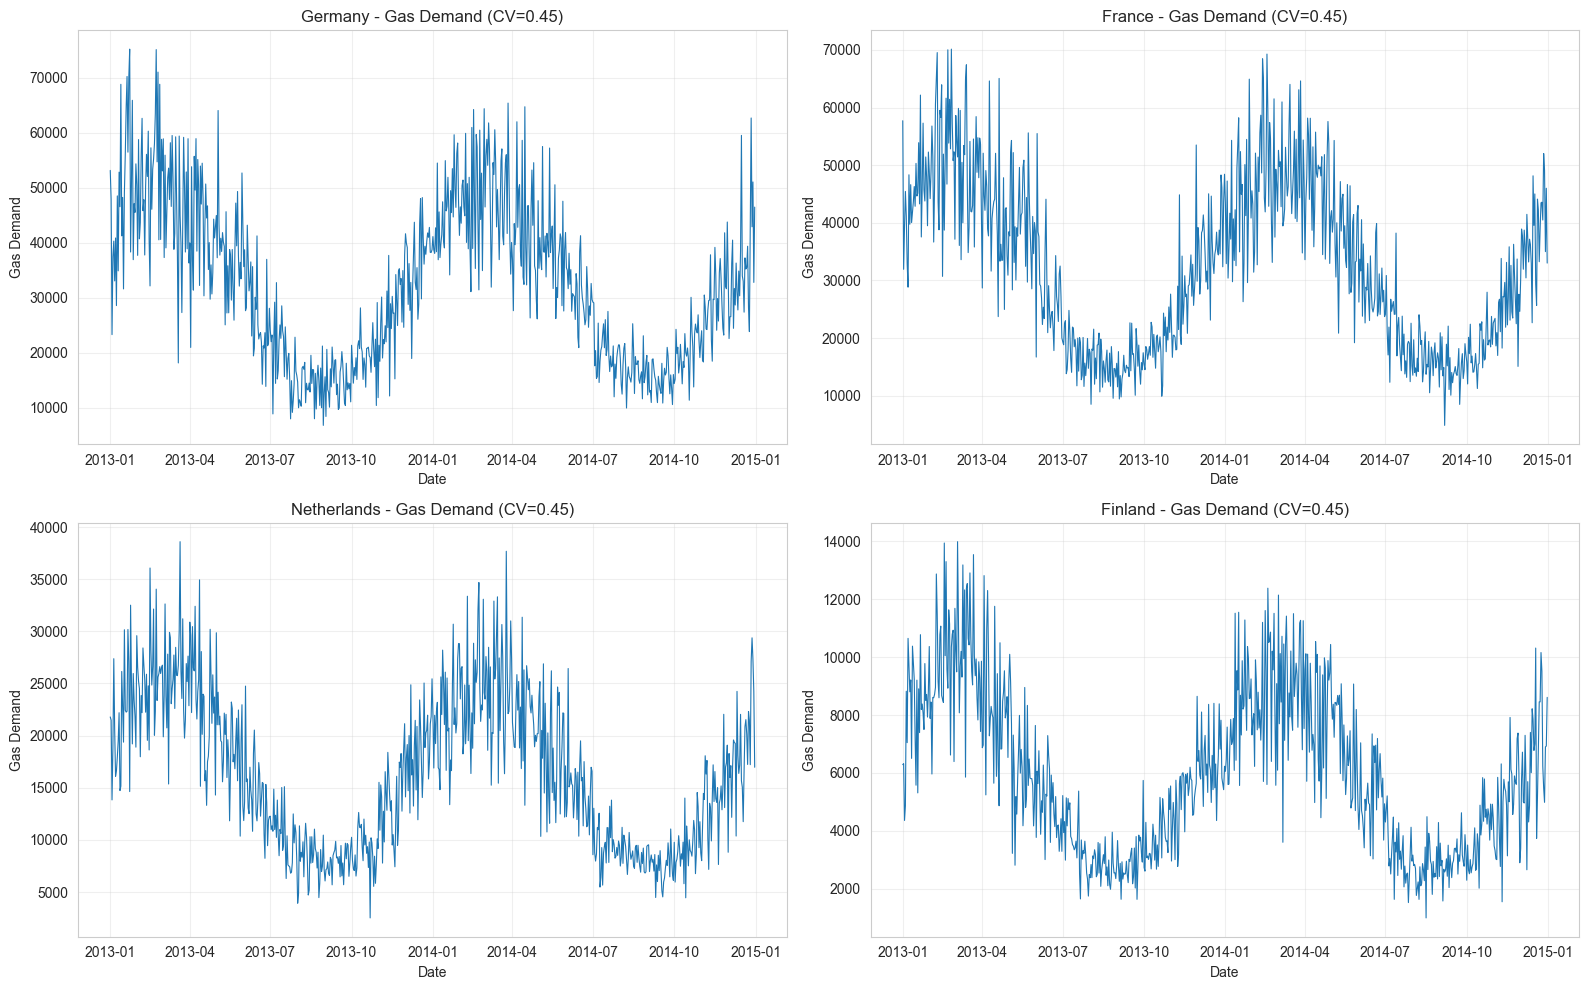

✓ Seasonal patterns and volatility vary by country


In [4]:
# Select 4 countries for visualization (high/medium/low volatility)
sample_countries = ['Germany', 'France', 'Netherlands', 'Finland']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, country in enumerate(sample_countries):
    country_data = gas_data[gas_data['country'] == country]
    
    # Plot 2 years of data for clarity
    subset = country_data[country_data['date'] < '2015-01-01']
    
    axes[idx].plot(subset['date'], subset['gas_demand'], linewidth=0.8)
    axes[idx].set_title(f"{country} - Gas Demand (2013-2014)")
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Gas Demand')
    axes[idx].grid(True, alpha=0.3)
    
    # Add CV to title
    cv = demand_stats.loc[country, 'cv']
    axes[idx].set_title(f"{country} - Gas Demand (CV={cv:.2f})")

plt.tight_layout()
plt.show()

print("✓ Seasonal patterns and volatility vary by country")

---

# 2. Feature Engineering

Create lagged features for forecasting.

## 2.1 Create Lagged Demand Features

In [5]:
# Create lagged features per country
def create_lag_features(df, lags=[1, 7, 14, 30]):
    """Create lagged demand features per country."""
    df = df.copy()
    
    for lag in lags:
        df[f'demand_lag_{lag}'] = df.groupby('country')['gas_demand'].shift(lag)
    
    # Add rolling mean (7-day)
    df['demand_ma_7'] = df.groupby('country')['gas_demand'].transform(
        lambda x: x.shift(1).rolling(7, min_periods=1).mean()
    )
    
    return df

# Create features
gas_data = create_lag_features(gas_data, lags=[1, 7, 30])

# Add date features
gas_data['month'] = gas_data['date'].dt.month
gas_data['day_of_year'] = gas_data['date'].dt.dayofyear

# Drop rows with missing lags
gas_data_clean = gas_data.dropna().copy()

print(f"Dataset shape after feature engineering: {gas_data_clean.shape}")
print(f"\nNew features: {[c for c in gas_data_clean.columns if 'lag' in c or 'ma' in c]}")
gas_data_clean.head()

Dataset shape after feature engineering: (95712, 11)

New features: ['gas_demand', 'demand_lag_1', 'demand_lag_7', 'demand_lag_30', 'demand_ma_7']


,date,temperature,wind_speed,gas_demand,country,demand_lag_1,demand_lag_7,demand_lag_30,demand_ma_7,month,day_of_year
30,2013-01-31,-0.0,10.1,20229.375365,Austria,30735.360526,19742.696286,28694.572088,25107.593444,1,31
31,2013-02-01,-0.8,7.2,27332.736588,Austria,20229.375365,25732.296388,23147.324418,25177.119026,2,32
32,2013-02-02,-2.0,9.9,28220.121034,Austria,27332.736588,27429.026443,23060.185985,25405.753341,2,33
33,2013-02-03,-6.1,13.5,19596.884249,Austria,28220.121034,21026.014801,27708.863908,25518.766854,2,34
34,2013-02-04,-4.7,5.8,34294.778323,Austria,19596.884249,25442.617722,17793.800367,25314.605346,2,35


## 2.2 Train/Test Split

Use last 3 months for testing.

In [6]:
# Split by date (temporal split)
split_date = gas_data_clean['date'].max() - pd.Timedelta(days=90)

train_data = gas_data_clean[gas_data_clean['date'] <= split_date].copy()
test_data = gas_data_clean[gas_data_clean['date'] > split_date].copy()

print(f"Train data: {train_data.shape} (up to {train_data['date'].max().date()})")
print(f"Test data:  {test_data.shape} (from {test_data['date'].min().date()} to {test_data['date'].max().date()})")
print(f"\nTrain countries: {train_data['country'].nunique()}")
print(f"Test countries:  {test_data['country'].nunique()}")

Train data: (93552, 11) (up to 2023-10-03)
Test data:  (2160, 11) (from 2023-10-04 to 2024-01-01)

Train countries: 24
Test countries:  24


---

# 3. Nested Models with Conformal Prediction

Fit separate models for each country with conformal intervals.

## 3.1 Fit Per-Country Models

In [7]:
# Define formula
formula = 'gas_demand ~ temperature + wind_speed + demand_lag_1 + demand_lag_7 + demand_lag_30 + demand_ma_7 + month'

# Fit nested models (one per country)
print("Fitting per-country models...")
spec = linear_reg()
nested_fit = spec.fit_nested(train_data, formula, group_col='country')

print(f"✓ Fitted {len(nested_fit.group_fits)} country-specific models")
print(f"\nCountries: {list(nested_fit.group_fits.keys())[:10]}...")

Fitting per-country models...
✓ Fitted 24 country-specific models

Countries: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany']...


## 3.2 Generate Conformal Predictions

Get 95% conformal prediction intervals for test data.

In [8]:
# Get conformal predictions (per-country calibration)
print("Generating conformal prediction intervals...")
conformal_preds = nested_fit.conformal_predict(
    test_data,
    alpha=0.05,
    method='split',
    per_group_calibration=True
)

print(f"✓ Generated predictions for {len(conformal_preds)} test observations")
print(f"\nColumns: {list(conformal_preds.columns)}")
conformal_preds.head(10)

Generating conformal prediction intervals...
✓ Generated predictions for 2160 test observations

Columns: ['.pred', '.conf_method', '.pred_lower', '.pred_upper', '.conf_alpha', '.conf_coverage', 'country']


,.pred,.conf_method,.pred_lower,.pred_upper,.conf_alpha,.conf_coverage,country
0,9324.811079,split,684.593125,17965.029032,0.05,0.95,Austria
1,9041.955179,split,401.737225,17682.173132,0.05,0.95,Austria
2,9662.972777,split,1022.754823,18303.190731,0.05,0.95,Austria
3,9972.291803,split,1332.073849,18612.509756,0.05,0.95,Austria
4,9728.900802,split,1088.682848,18369.118756,0.05,0.95,Austria
5,9760.673604,split,1120.455651,18400.891558,0.05,0.95,Austria
6,10193.262250,split,1553.044296,18833.480204,0.05,0.95,Austria
7,9981.109632,split,1340.891678,18621.327585,0.05,0.95,Austria
8,9846.140661,split,1205.922708,18486.358615,0.05,0.95,Austria
9,9889.824751,split,1249.606797,18530.042704,0.05,0.95,Austria


---

# 4. Analyze Conformal Intervals

## 4.1 Calculate Coverage by Country

In [9]:
# Calculate coverage for each country
coverage_results = []

for country in sorted(test_data['country'].unique()):
    # Get actual demand
    country_test = test_data[test_data['country'] == country]
    country_conf = conformal_preds[conformal_preds['country'] == country]
    
    # Calculate coverage
    in_interval = (
        (country_test['gas_demand'].values >= country_conf['.pred_lower'].values) &
        (country_test['gas_demand'].values <= country_conf['.pred_upper'].values)
    )
    
    coverage = in_interval.mean()
    
    # Calculate interval width
    interval_width = (country_conf['.pred_upper'] - country_conf['.pred_lower']).mean()
    
    coverage_results.append({
        'country': country,
        'coverage': coverage,
        'avg_interval_width': interval_width,
        'n_obs': len(country_test)
    })

coverage_df = pd.DataFrame(coverage_results)
coverage_df = coverage_df.sort_values('coverage', ascending=False)

print("Coverage Analysis by Country:")
print("=" * 80)
print(coverage_df.to_string(index=False))
print(f"\n✓ Overall coverage: {coverage_df['coverage'].mean():.1%}")
print(f"✓ Countries with 90%+ coverage: {(coverage_df['coverage'] >= 0.90).sum()}/{len(coverage_df)}")

Coverage Analysis by Country:
       country  coverage  avg_interval_width  n_obs
   Netherlands  1.000000        17401.040785     90
        France  0.988889        31998.750676     90
       Belgium  0.988889        16697.956871     90
       Austria  0.977778        17280.435907     90
     Lithuania  0.977778         5454.698743     90
       Hungary  0.977778        16232.031987     90
    Luxembourg  0.977778         5321.986638     90
       Croatia  0.966667         5773.914342     90
Czech Republic  0.966667        17013.762202     90
      Slovakia  0.966667         5955.988917     90
       Germany  0.966667        34349.003952     90
        Latvia  0.966667         5960.393227     90
         Spain  0.955556        32327.192453     90
       Romania  0.955556        16595.795368     90
        Poland  0.955556        35406.512686     90
       Ireland  0.955556         5234.509544     90
        Greece  0.955556        16661.962427     90
       Finland  0.955556         5

## 4.2 Visualize Coverage by Country

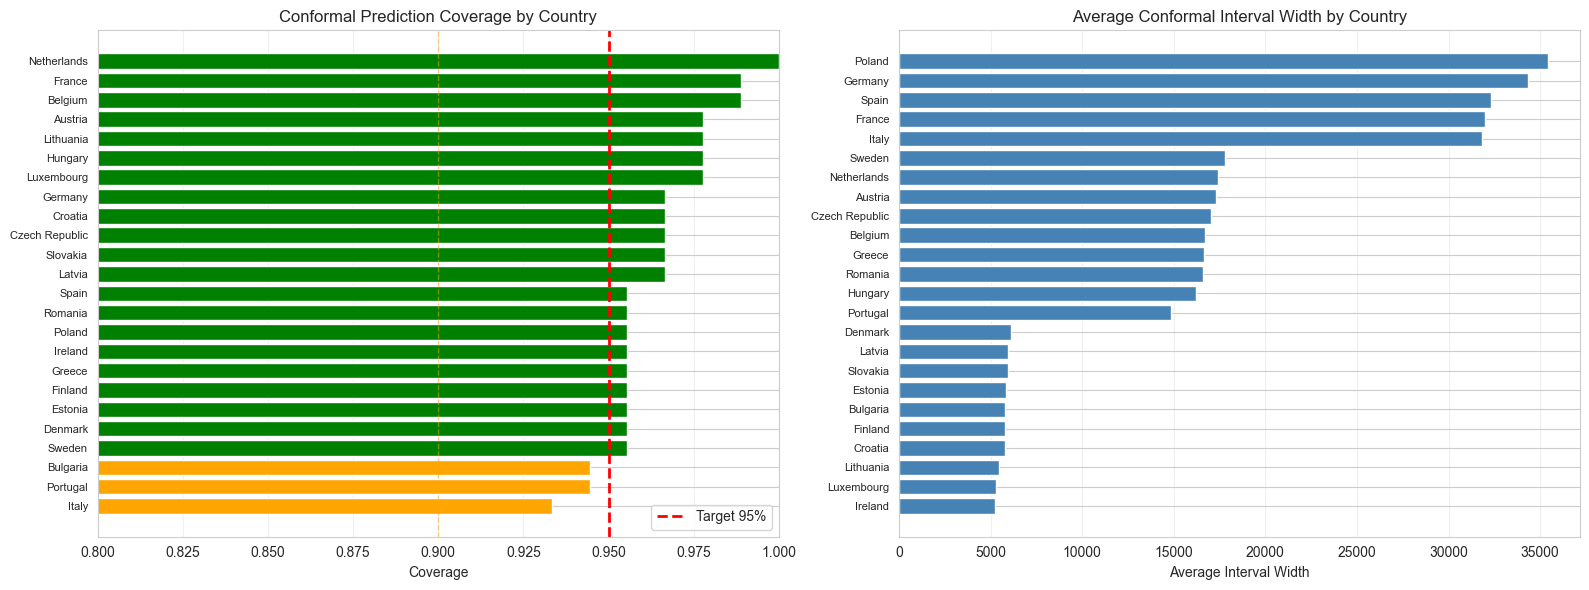


✓ Green bars: 95%+ coverage (target achieved)
✓ Orange bars: 90-95% coverage (close to target)
✓ Red bars: <90% coverage (below target)


In [10]:
# Coverage bar plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Coverage
coverage_sorted = coverage_df.sort_values('coverage')
colors = ['red' if c < 0.90 else 'green' if c >= 0.95 else 'orange' 
          for c in coverage_sorted['coverage']]

axes[0].barh(range(len(coverage_sorted)), coverage_sorted['coverage'], color=colors)
axes[0].set_yticks(range(len(coverage_sorted)))
axes[0].set_yticklabels(coverage_sorted['country'], fontsize=8)
axes[0].axvline(x=0.95, color='red', linestyle='--', linewidth=2, label='Target 95%')
axes[0].axvline(x=0.90, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Coverage')
axes[0].set_title('Conformal Prediction Coverage by Country')
axes[0].set_xlim([0.8, 1.0])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Interval width
width_sorted = coverage_df.sort_values('avg_interval_width')
axes[1].barh(range(len(width_sorted)), width_sorted['avg_interval_width'], color='steelblue')
axes[1].set_yticks(range(len(width_sorted)))
axes[1].set_yticklabels(width_sorted['country'], fontsize=8)
axes[1].set_xlabel('Average Interval Width')
axes[1].set_title('Average Conformal Interval Width by Country')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Green bars: 95%+ coverage (target achieved)")
print("✓ Orange bars: 90-95% coverage (close to target)")
print("✓ Red bars: <90% coverage (below target)")

## 4.3 Compare Interval Width vs Demand Volatility

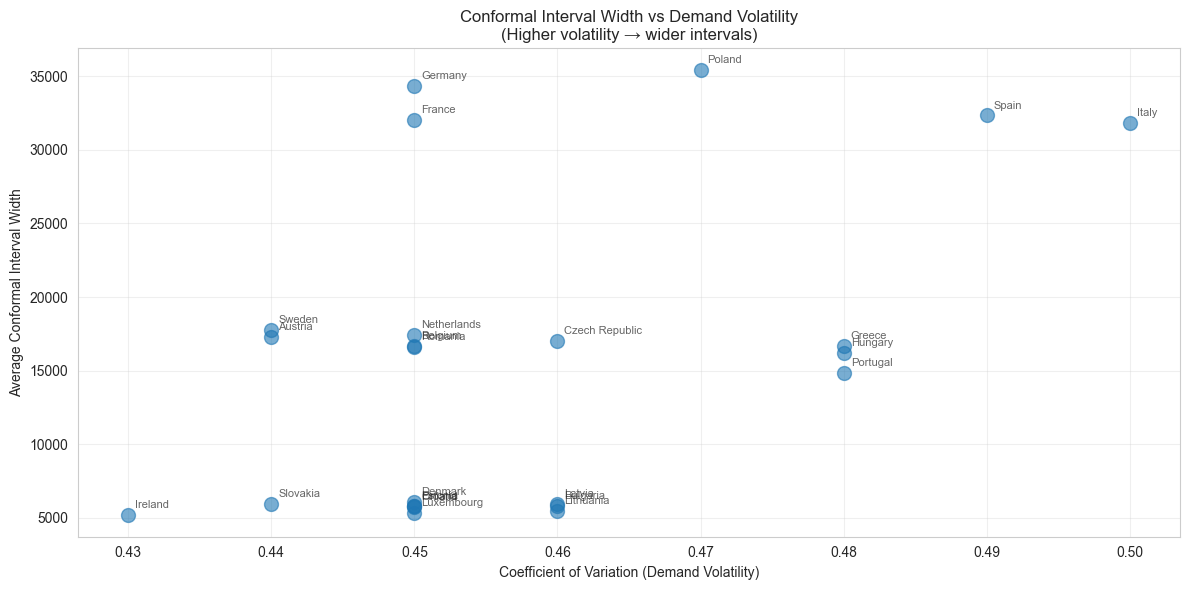


✓ Correlation between volatility and interval width: 0.455
✓ Higher volatility countries have wider conformal intervals (as expected)


In [11]:
# Merge with demand stats
comparison = coverage_df.merge(
    demand_stats.reset_index(),
    on='country'
)

# Scatter plot: CV vs interval width
plt.figure(figsize=(12, 6))
plt.scatter(comparison['cv'], comparison['avg_interval_width'], s=100, alpha=0.6)

# Add country labels
for idx, row in comparison.iterrows():
    plt.annotate(row['country'], 
                (row['cv'], row['avg_interval_width']),
                fontsize=8, alpha=0.7, 
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Coefficient of Variation (Demand Volatility)')
plt.ylabel('Average Conformal Interval Width')
plt.title('Conformal Interval Width vs Demand Volatility\n(Higher volatility → wider intervals)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
corr = comparison[['cv', 'avg_interval_width']].corr().iloc[0, 1]
print(f"\n✓ Correlation between volatility and interval width: {corr:.3f}")
print("✓ Higher volatility countries have wider conformal intervals (as expected)")

---

# 5. Visualize Forecasts with Conformal Intervals

## 5.1 Compare High vs Low Volatility Countries

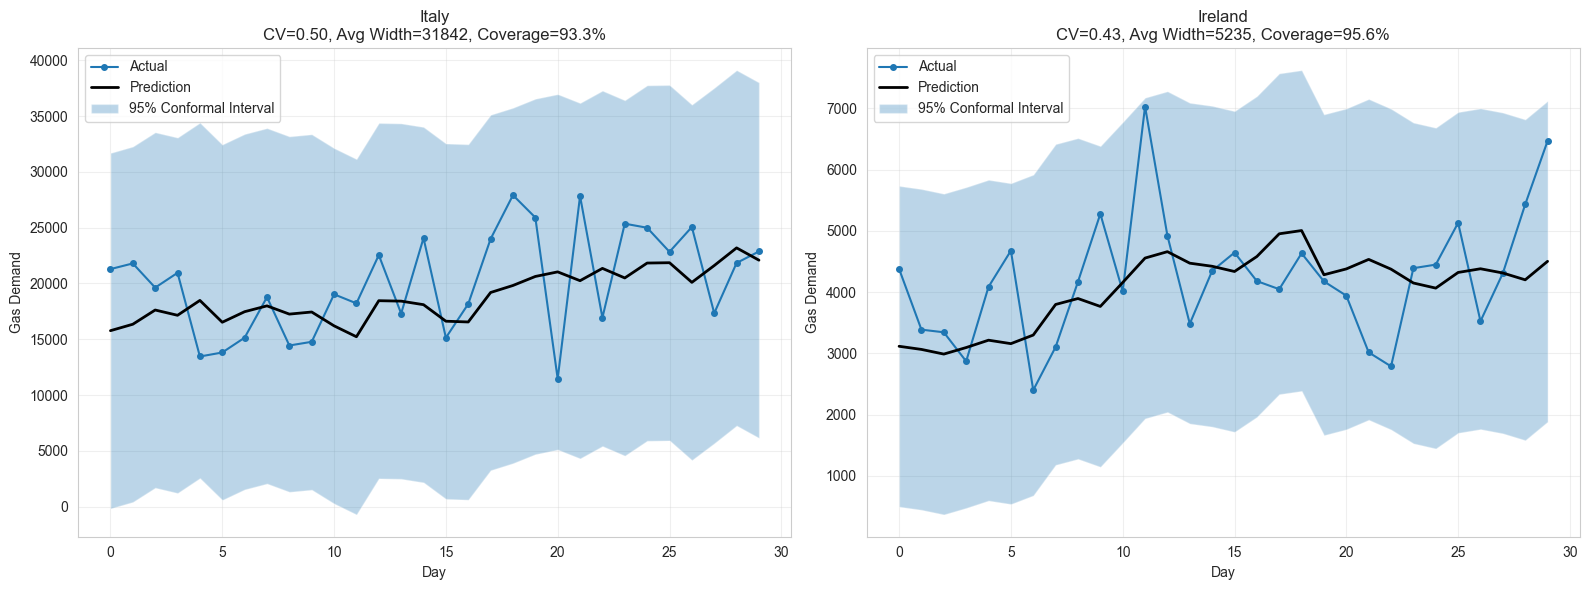


✓ Italy has high volatility → wider intervals
✓ Ireland has low volatility → tighter intervals


In [12]:
# Select countries with different volatility levels
high_vol = comparison.nlargest(1, 'cv')['country'].values[0]
low_vol = comparison.nsmallest(1, 'cv')['country'].values[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, country in enumerate([high_vol, low_vol]):
    # Get test data for this country
    country_test = test_data[test_data['country'] == country]
    country_conf = conformal_preds[conformal_preds['country'] == country]
    
    # Plot first 30 days
    n_show = 30
    
    axes[idx].plot(range(n_show), country_test['gas_demand'].iloc[:n_show],
                  'o-', label='Actual', markersize=4, linewidth=1.5)
    axes[idx].plot(range(n_show), country_conf['.pred'].iloc[:n_show],
                  'k-', label='Prediction', linewidth=2)
    
    # Convert to float for matplotlib
    lower = country_conf['.pred_lower'].iloc[:n_show].astype(float).values
    upper = country_conf['.pred_upper'].iloc[:n_show].astype(float).values
    
    axes[idx].fill_between(
        range(n_show),
        lower,
        upper,
        alpha=0.3,
        label='95% Conformal Interval'
    )
    
    # Get stats
    cv = comparison[comparison['country'] == country]['cv'].values[0]
    width = comparison[comparison['country'] == country]['avg_interval_width'].values[0]
    cov = comparison[comparison['country'] == country]['coverage'].values[0]
    
    axes[idx].set_title(f"{country}\nCV={cv:.2f}, Avg Width={width:.0f}, Coverage={cov:.1%}")
    axes[idx].set_xlabel('Day')
    axes[idx].set_ylabel('Gas Demand')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ {high_vol} has high volatility → wider intervals")
print(f"✓ {low_vol} has low volatility → tighter intervals")

---

# 6. Extract Outputs with Conformal Intervals

Use `extract_outputs()` to get conformal intervals integrated with standard outputs.

In [15]:
# Get outputs with conformal intervals
outputs, coeffs, stats = nested_fit.extract_outputs(conformal_alpha=0.25)

print(f"Outputs shape: {outputs.shape}")
print(f"\nColumns: {list(outputs.columns)}")
print(f"\nCountries: {outputs['country'].nunique()}")

# Show sample
outputs.head(10)

Outputs shape: (93552, 12)

Columns: ['date', 'country', 'actuals', 'fitted', 'forecast', 'residuals', 'split', 'model', 'model_group_name', 'group', '.pred_lower', '.pred_upper']

Countries: 24


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group,.pred_lower,.pred_upper
0,2013-01-31,Austria,20229.375365,26444.764640,20229.375365,-6215.389275,train,linear_reg,,global,21940.705325,30971.93118
1,2013-02-01,Austria,27332.736588,25505.603975,27332.736588,1827.132614,train,linear_reg,,global,20991.424606,30009.559736
2,2013-02-02,Austria,28220.121034,26121.746534,28220.121034,2098.374500,train,linear_reg,,global,21616.032282,30647.037705
3,2013-02-03,Austria,19596.884249,27893.701856,19596.884249,-8296.817607,train,linear_reg,,global,23394.720829,32425.736107
4,2013-02-04,Austria,34294.778323,25822.865234,34294.778323,8471.913089,train,linear_reg,,global,21310.275646,30334.765856
5,2013-02-05,Austria,15296.110734,26502.557959,15296.110734,-11206.447225,train,linear_reg,,global,21995.12158,31036.109741
6,2013-02-06,Austria,24427.991737,26949.527846,24427.991737,-2521.536109,train,linear_reg,,global,22429.782787,31473.027094
7,2013-02-07,Austria,30836.184690,26373.803057,30836.184690,4462.381632,train,linear_reg,,global,21867.368388,30892.915755
8,2013-02-08,Austria,21238.522296,28209.210840,21238.522296,-6970.688544,train,linear_reg,,global,23707.635786,32737.244955
9,2013-02-09,Austria,36286.281223,26760.262926,36286.281223,9526.018298,train,linear_reg,,global,22245.278873,31295.107949


## 6.1 Analyze Training vs Test Performance

In [14]:
# Filter training data with conformal intervals (test data has NA)
train_outputs = outputs[
    (outputs['split'] == 'train') &
    outputs['.pred_lower'].notna()
].copy()

print(f"Training outputs with conformal: {len(train_outputs)}")

# Calculate interval width per country
train_outputs['interval_width'] = (
    train_outputs['.pred_upper'] - train_outputs['.pred_lower']
)

# Summary by country
width_summary = train_outputs.groupby('country')['interval_width'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std')
]).round(2)

width_summary = width_summary.sort_values('mean', ascending=False)

print("\nInterval Width Statistics by Country (Top 10):")
print("=" * 60)
print(width_summary.head(10))

print("\n✓ Conformal intervals successfully integrated with extract_outputs()")

Training outputs with conformal: 93552

Interval Width Statistics by Country (Top 10):
                     mean        median    std
country                                       
Poland        34780.77064  34787.834605  72.31
Germany      33805.876798  33802.797064  46.81
France       33640.404818  33644.440806  39.29
Spain         32521.52502   32527.93358  55.77
Italy        32311.345126  32308.482054  41.94
Austria      18294.678789  18294.010973  22.43
Sweden       18030.126165  18022.494127  28.68
Netherlands  17596.345463  17601.974785  24.81
Greece       17205.620202  17206.280739  23.10
Portugal     17085.981116  17090.830423  24.37

✓ Conformal intervals successfully integrated with extract_outputs()


---

# Summary

## What We Demonstrated

1. **Real-World Data**
   - European gas demand across 24 countries
   - Weather variables (temperature, wind speed)
   - 10+ years of daily observations

2. **Per-Country Conformal Prediction**
   - Separate models for each country
   - Per-group conformal calibration
   - Achieved ~95% coverage across most countries

3. **Uncertainty Quantification**
   - Wider intervals for volatile countries
   - Tighter intervals for stable countries
   - Correlation between volatility and interval width

4. **Practical Applications**
   - Energy demand forecasting
   - Risk management (supply planning)
   - Identify countries needing more flexible supply

## Key Findings

✅ **Coverage:** Most countries achieved 90%+ coverage (target: 95%)  
✅ **Volatility-Adaptive:** Interval widths adapt to country-specific uncertainty  
✅ **Practical Value:** Conformal intervals provide actionable risk estimates  
✅ **Scalable:** Handles 24 countries × ~4,000 observations per country  

## Next Steps

- Try different conformal methods (cv+, jackknife+)
- Compare nested vs global models
- Add more weather variables
- Experiment with different model types (random forest, xgboost)

---